**Separa componentes (Análisis de componentes conectados)**

In [1]:
def extraerCerebro(rutaArchivo):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.filters import threshold_otsu
    from skimage.morphology import convex_hull_image


    img = cv2.imread(rutaArchivo, cv2.IMREAD_COLOR)
    print(img.shape)


    dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)



    inmax=np.amax(img)
    c=255/(np.log(1+inmax))
    Iout=np.log(img[:,:]+1)
    Iout=c*Iout[:,:]
    Iout=Iout.astype(np.uint8)




    ##CONTRASTRE CON CORRECCIÓN GAMMA
    x=np.linspace(0, 255, num=256)
    vg=np.array([0.05, 0.1,0.2, 0.5, 1, 2, 5, 10]) 
    for i in vg:
        c=255/(255**i)
        gamma=c*(x**i)

    maxi = np.amax(Iout)
    vg=1.8  #Change the gamma value
    c=255/(maxi**vg)
    I2=c*np.float32(Iout)**vg
    I2=I2.astype(np.uint8)
    inmax = np.amax(I2)
    inmin = np.amin(I2)
    print('min=',inmin,'max=',inmax)



    def binariza(imagem,Cerebro=True):
        if Cerebro:
            t = threshold_otsu(imagem)
        else:#Crânio
            t = 0
        imagem_binaria = imagem.copy()
        imagem_binaria[imagem_binaria<=t] = 0
        imagem_binaria[imagem_binaria>t] = 255
        return imagem_binaria

    Gbin = binariza(cv2.cvtColor(I2,cv2.COLOR_BGR2GRAY))



    from PIL import Image
    from scipy import signal as sci
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage.morphology import binary_fill_holes, binary_opening
    %matplotlib inline
    import matplotlib.image as mpimg
    from skimage import morphology as morph
    from scipy import ndimage as nd
    import sys,os
    from skimage.filters import threshold_otsu, threshold_isodata, threshold_li, threshold_local, threshold_minimum 
    from skimage import feature
    from skimage.filters import threshold_local as threshold_adaptative
    import heapq
    import matplotlib.patches as mpatches
    from skimage.morphology import convex_hull_image
    import pandas as pd
    import seaborn as sns
    from scipy.signal import convolve2d as sc_conv
    from matplotlib.colors import colorConverter
    import matplotlib as mpl
    import time

    def detecta_borda_conexa(imagem_binaria): 
        cranio_convexo = convex_hull_image(binary_fill_holes(imagem_binaria))# preenche a imagem
        borda_cranio = feature.canny(cranio_convexo)#extrai a borda
        return borda_cranio

    def detecta_componente_conexa(imagem_binaria,mostrar_Passos=False):
        label_aux = morph.label(imagem_binaria)
        label_ret = morph.label(imagem_binaria)
        if mostrar_Passos==True:
            pass
        valor_disco = 0
        
        #Passo 1 - Detecção da Borda do Crânio via Canny
        contorno_cranio_binario = detecta_borda_conexa(imagem_binaria)
        if mostrar_Passos==True:
            pass

        #Passo 2 - Detecção da Tonalidade do Fundo
        tonalidade_fundo = (np.argmax(np.bincount(label_ret[0:20,0:20].ravel())))
        print("tonalidad de fondo:",tonalidade_fundo)
        for ab in range(200):
            #print(ab)
            contorno_cranio = label_ret[contorno_cranio_binario==True]
            [IMX,IMY] = imagem_binaria.shape
            
            #Passo 3 - Detecção da Parte Central do Cérebro (sem fundo)
            array_centro = label_ret[IMX//2-25:IMX//2+25,IMY//2-25:IMY//2+25]
            array_centro = array_centro[array_centro!=tonalidade_fundo]
            max_centro = (np.argmax(np.bincount(array_centro.ravel())))# retorna o pixel mais frequente na imagem array_centro, correspondendo ao valor do cérebro

            #Passo 4 - Verificação da Presença da Intensidade da Borda no Centro 
            if(max_centro in contorno_cranio):
                valor_disco = valor_disco + 1
                label_ret = morph.opening(label_aux,morph.disk(valor_disco))
                label_ret = morph.label(label_ret) 
                #save_without_spacing("TrabalhoMeninge_7_"+str(valor_disco)+"comp.png")            
            else:
                break
        print("max_centro:",max_centro)

        #print(valor_disco)
        if(valor_disco == 0):
            label_ret = label_aux
        return [label_ret,tonalidade_fundo, array_centro]

    [LC,tonalidade_fundo,array_centro] = detecta_componente_conexa(Gbin,True)



    LCBin = binariza(LC,True)



    from scipy import ndimage
    label_im, nb_labels = ndimage.label(LCBin)
    nb_labels # how many regions?


    sizes = ndimage.sum(LCBin, label_im, range(nb_labels + 1))

    print(sizes)
    print(max(sizes))

    mask_size = sizes < max(sizes)

    remove_pixel = mask_size[label_im]
    remove_pixel.shape

    label_im[remove_pixel] = 0

    print(type(label_im))
    print(label_im)




    from skimage import color
    imgGray = color.rgb2gray(img)
    out = img.copy()
    for i in range(label_im.shape[0]):
        for j in range(label_im.shape[1]):
            if(label_im[i][j]):
                out[i][j]=img[i][j]
            else:
                out[i][j]=255

    fig6=plt.figure(figsize = (8,8))
    a = fig6.add_subplot(1, 2, 1)
    plt.imshow(img, cmap='gray',vmin=0,vmax=2**8)
    plt.axis('off');

    b = fig6.add_subplot(1, 2, 2)
    plt.imshow(out, cmap='gray',vmin=0,vmax=2**8)
    plt.axis('off');

    return out



Data/CK/2/img001out.bmp Data/CK/2/img001.bmp
(378, 378, 3)


/tmp/ipykernel_265/1802348387.py:19: RuntimeWarning: divide by zero encountered in log
  Iout=np.log(img[:,:]+1)


min= 0 max= 254
tonalidad de fondo: 0
max_centro: 37
[      0.  100215.   14280.    6120. 2776950.    9180.  115260.   18105.
   48705.   26265.    3315.    3315.    4590.    4590.    7395.    8925.
   10200.  161160.   17340. 1053405.    5355.   31110.    6120.    3315.
    3315.    3315.    3315.   36465.    3315.   11220.   15555.    8415.
  171105.   14280.    4590.   97665.   14025.   20655.    3315.    4590.
   10200.    3315.   18105.    4590.   16320.    4590.   21165.   11475.
    3315.]
2776950.0
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Data/CK/2/img002out.bmp Data/CK/2/img002.bmp
(378, 378, 3)


/tmp/ipykernel_265/1802348387.py:19: RuntimeWarning: divide by zero encountered in log
  Iout=np.log(img[:,:]+1)


min= 0 max= 254
tonalidad de fondo: 0
max_centro: 10
[      0.    5865.  241740.    5610.    4590.  485775.  122910.   54060.
    9435.    7140.  432990.    4590.   15555.   52020.  135915.   22950.
   32640.  375615.    8415.   26265. 1113585.  443700.   58650.    8160.
    3315.   12495.   16830.   16320.    5355.    5865.    3315.    4590.]
1113585.0
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Data/CK/2/img003out.bmp Data/CK/2/img003.bmp
(378, 378, 3)
min= 0 max= 254
tonalidad de fondo: 0
max_centro: 8
[      0.   22695.   10965.   54315.   41055.   68340.    7395.    9180.
 2036430.    9690.    9690.   10455.   13005.    7395.    9180.   15810.
   16830.   17850.  677025.    7395.   36720.   16575.    7395.]
2036430.0
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Data/CK/2/img004out.bmp 

[ WARN:0@17.991] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('Data/CK/2/img028.bmp'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

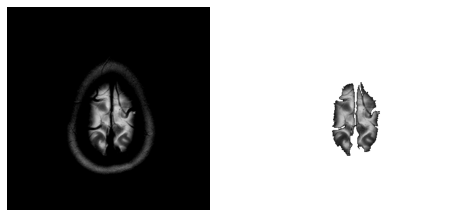

In [2]:
import cv2
pacienteArcivo="Data/CK/2/"
for i in range(1,30):
    num = str(i)
    num = num.zfill(3)
    name = pacienteArcivo+"img"+num+".bmp"
    outName = pacienteArcivo+"img"+num+"out"+".bmp"
    print(outName,name)
    out = extraerCerebro(name)

    #guardar imaen
    cv2.imwrite(outName,out)